# Imports

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import os
import json
import numpy as np
from sklearn.cluster import OPTICS, DBSCAN
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import time
import csv

# Dataset exploring

In [0]:
# Load first 10 elemets of ground truth
gt_path = "/content/drive/My Drive/agiw/gt.csv"
reader = pd.read_csv(gt_path, iterator=True)
reader.get_chunk(10)

,left_target_attribute,right_target_attribute,left_instance_attribute,right_instance_attribute,left_instance_value,right_instance_value,label
0,auto_focus_beam,auto_focus_beam,www.shopmania.in//1547//af illuminator,www.shopmania.in//1066//af illuminator,yes,yes,1
1,auto_focus_beam,auto_focus_beam,www.shopmania.in//859//af illuminator,www.ilgs.net//24//auto focus af assist beam,yes,yes,1
2,auto_focus_beam,auto_focus_beam,www.canon-europe.com//59//af assist beam,www.shopmania.in//858//af illuminator,yes,yes,1
3,auto_focus_beam,auto_focus_beam,www.shopmania.in//1458//af illuminator,www.cambuy.com.au//22//af assist beam,yes,yes,1
4,auto_focus_beam,auto_focus_beam,www.shopmania.in//1101//af illuminator,www.shopmania.in//858//af illuminator,yes,yes,1
5,auto_focus_beam,auto_focus_beam,www.shopmania.in//1547//af illuminator,www.cambuy.com.au//22//af assist beam,yes,yes,1
6,auto_focus_beam,auto_focus_beam,www.shopmania.in//1478//af illuminator,www.ilgs.net//24//auto focus af assist beam,yes,yes,1
7,auto_focus_beam,auto_focus_beam,www.shopmania.in//926//af illuminator,www.ilgs.net//134//auto focus af assist beam,yes,no,1
8,auto_focus_beam,auto_focus_beam,www.shopmania.in//1490//af illuminator,www.cambuy.com.au//103//af assist beam,yes,intermittent firing of built-in flash or emitt...,1
9,auto_focus_beam,auto_focus_beam,www.shopmania.in//1406//af illuminator,www.shopmania.in//1009//af illuminator,yes,yes,1


In [38]:
# Read ground truth elements chunk by chunk
reader = pd.read_csv(gt_path, chunksize=1000)
gt = pd.DataFrame()
for i, chunk in enumerate(reader):
    gt = pd.concat([gt, chunk])
    if i > 10:
        break
gt

,left_target_attribute,right_target_attribute,left_instance_attribute,right_instance_attribute,left_instance_value,right_instance_value,label
0,auto_focus_beam,auto_focus_beam,www.shopmania.in//1547//af illuminator,www.shopmania.in//1066//af illuminator,yes,yes,1
1,auto_focus_beam,auto_focus_beam,www.shopmania.in//859//af illuminator,www.ilgs.net//24//auto focus af assist beam,yes,yes,1
2,auto_focus_beam,auto_focus_beam,www.canon-europe.com//59//af assist beam,www.shopmania.in//858//af illuminator,yes,yes,1
3,auto_focus_beam,auto_focus_beam,www.shopmania.in//1458//af illuminator,www.cambuy.com.au//22//af assist beam,yes,yes,1
4,auto_focus_beam,auto_focus_beam,www.shopmania.in//1101//af illuminator,www.shopmania.in//858//af illuminator,yes,yes,1
...,...,...,...,...,...,...,...
11995,auto_focus_mode,auto_focus_mode,www.mypriceindia.com//85//auto focus,www.mypriceindia.com//72//auto focus,"yes, contrast detect, phase detect, multi-area...","yes, ttl phase detection",1
11996,auto_focus_mode,auto_focus_mode,www.camerafarm.com.au//783//autofocus system,www.ilgs.net//98//auto focusing af modes,hybrid autofocus (phase detection/contrast-det...,"continuous auto focus, face detection, multi p...",1
11997,auto_focus_mode,auto_focus_mode,www.price-hunt.com//942//auto focus,www.cambuy.com.au//73//autofocus af,"ttl secondary image-registration, phase detection",contrast-detect af,1
11998,auto_focus_mode,auto_focus_mode,www.camerafarm.com.au//796//focus modes,cammarkt.com//186//focus type,auto af-s/af-c selection (af-a)\ncontinuous-se...,autofocus & manual focus,1


# Dataset loading

In [0]:
# I load the attributes in the specs DataFrame. Specs must be in folder ./data/specs
specs = pd.DataFrame()
specs_dir = os.path.join("data", "specs")
i = 0
for root_dir, _, files in os.walk(specs_dir):
    for file_name in files:
        if file_name.endswith(".json"):
            file_path = os.path.join(root_dir, file_name)
            
            with open(file_path, 'r') as json_file:
                json_dict = json.load(json_file)
                
            json_names = list(json_dict.keys())
            json_values = list(json_dict.values())
            json_np = np.vstack([json_names, json_values]).T
            json_df = pd.DataFrame(json_np, columns=["name", "value"])
            specs = pd.concat([specs, json_df])
            
            if i % 1000 == 0:
                print("Loaded", i, "files...")
            i += 1
specs

Loaded 0 rows...
Loaded 1000 rows...
Loaded 2000 rows...
Loaded 3000 rows...
Loaded 4000 rows...
Loaded 5000 rows...
Loaded 6000 rows...
Loaded 7000 rows...
Loaded 8000 rows...
Loaded 9000 rows...
Loaded 10000 rows...
Loaded 11000 rows...
Loaded 12000 rows...
Loaded 13000 rows...
Loaded 14000 rows...
Loaded 15000 rows...
Loaded 16000 rows...
Loaded 17000 rows...
Loaded 18000 rows...
Loaded 19000 rows...
Loaded 20000 rows...
Loaded 21000 rows...
Loaded 22000 rows...
Loaded 23000 rows...
Loaded 24000 rows...
Loaded 25000 rows...
Loaded 26000 rows...
Loaded 27000 rows...
Loaded 28000 rows...
Loaded 29000 rows...


,name,value
0,<page title>,Buy Canon EOS 5D Mark III Digital Camera (Body...
1,actual weight,33.50 oz
2,audio input type,Microphone
3,battery technology,Lithium ion
4,camera type,SLR camera
...,...,...
8,lens tele mm,224
9,lens wide mm,28
10,mpn,8195B010AA
11,optical zoom,5x


# Demo di clustering con OPTICS

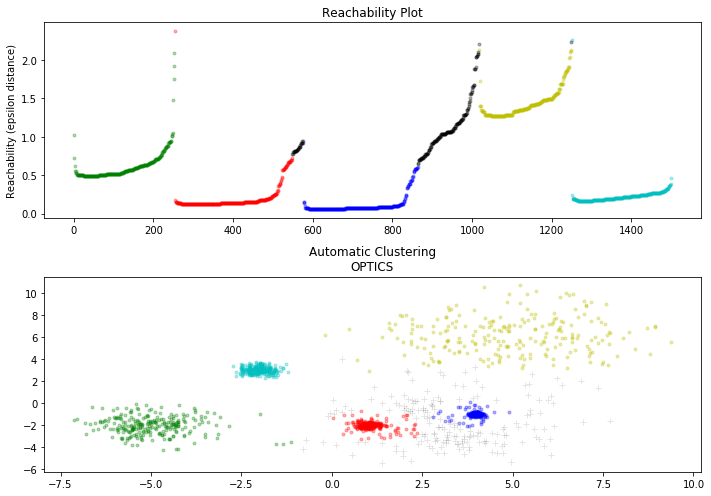

In [0]:
# Generate sample data

np.random.seed(0)
n_points_per_cluster = 250

C1 = [-5, -2] + .8 * np.random.randn(n_points_per_cluster, 2)
C2 = [4, -1] + .1 * np.random.randn(n_points_per_cluster, 2)
C3 = [1, -2] + .2 * np.random.randn(n_points_per_cluster, 2)
C4 = [-2, 3] + .3 * np.random.randn(n_points_per_cluster, 2)
C5 = [3, -2] + 1.6 * np.random.randn(n_points_per_cluster, 2)
C6 = [5, 6] + 2 * np.random.randn(n_points_per_cluster, 2)
X = np.vstack((C1, C2, C3, C4, C5, C6))

clust = OPTICS(min_samples=50, xi=.05, min_cluster_size=.05)

# Run the fit
clust.fit(X)

space = np.arange(len(X))
# Produce un array ordinato che indica la "distanza" (raggiungibilità) di ogni punto dal suo cluster.
reachability = clust.reachability_[clust.ordering_]
# Produce un array ordinato che indica il cluster di appartenenza di ogni punto (mediante un ID).
labels = clust.labels_[clust.ordering_]
# I precedenti array sono ordinati in modo tale che i punti vicini nello spazio vettoriale siano adiacenti nell'array.

plt.figure(figsize=(10, 7))
G = gridspec.GridSpec(2, 1)
ax1 = plt.subplot(G[0, :])
ax2 = plt.subplot(G[1, :])

# Reachability plot
colors = ['g.', 'r.', 'b.', 'y.', 'c.']
for klass, color in zip(range(0, 5), colors):
    # Prende gli indici di tutti i punti che appartengono alla classe klass.
    Xk = space[labels == klass]
    # Prende la raggiungibilità di tutti i punti che appartengono alla classe klass.
    Rk = reachability[labels == klass]
    # Plotta il grafico inidice/raggiungibilità
    ax1.plot(Xk, Rk, color, alpha=0.3)
# Plotta gli outliers (quelli con raggiungibilità troppo alta), che sono assegnati al cluster -1 (nessun cluster).
ax1.plot(space[labels == -1], reachability[labels == -1], 'k.', alpha=0.3)
ax1.set_ylabel('Reachability (epsilon distance)')
ax1.set_title('Reachability Plot')

# OPTICS
colors = ['g.', 'r.', 'b.', 'y.', 'c.']
for klass, color in zip(range(0, 5), colors):
    # Prende tutti i punti che appartengono alla classe klass.
    Xk = X[clust.labels_ == klass]
    # Plotta i punti della classe klass.
    ax2.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
# Plotta i punti della classe -1.
ax2.plot(X[clust.labels_ == -1, 0], X[clust.labels_ == -1, 1], 'k+', alpha=0.1)
ax2.set_title('Automatic Clustering\nOPTICS')

plt.tight_layout()
plt.show()

In [0]:
clust.ordering_

array([  0,   3,   6, ..., 908, 873, 866])

In [0]:
clust.reachability_

array([       inf, 0.8851258 , 0.7643838 , ..., 1.9108775 , 1.27370383,
       1.34376381])

In [0]:
clust.reachability_[clust.ordering_]

array([       inf, 1.02299291, 0.72157342, ..., 0.37733713, 0.38277529,
       0.46184072])

In [0]:
clust.labels_

array([0, 0, 0, ..., 3, 3, 3])

In [0]:
np.unique(clust.labels_)

array([-1,  0,  1,  2,  3,  4])

In [0]:
clust.labels_[clust.ordering_]

array([0, 0, 0, ..., 4, 4, 4])

# Demo di clustering con DBSCAN

Estimated number of clusters: 3
Estimated number of noise points: 18
Homogeneity: 0.953
Completeness: 0.883
V-measure: 0.917
Adjusted Rand Index: 0.952
Adjusted Mutual Information: 0.916
Silhouette Coefficient: 0.626


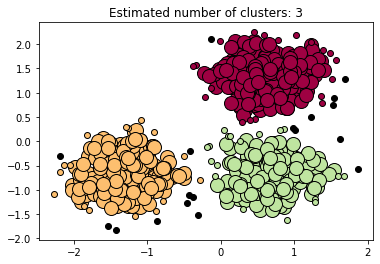

In [0]:
# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4,
                            random_state=0)
# Qua normalizza ma ho visto che con gli embeddings non è opportuno normalizzare (si perde informazione
# sulla lunghezza dei vettori.
X = StandardScaler().fit_transform(X)

# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
# Fa un array di zeri lungo quanto il numero di esempi.
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
# Mette true negli elementi dell'array che corrispondono ai core samples, cioè esempi che sono in aree dense.
core_samples_mask[db.core_sample_indices_] = True
# Array dove ogni elemento corrisponde a un esempio e il valore è il cluster di appartenenza.
labels = db.labels_

# Numero di cluster trovati.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
# Numero di esempi classificati come rumore (cluster -1).
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
# L'omogeneità è alta se i cluster contengono
# elementi che fanno parte della stessa classe (quindi non contano le label assolute ma i cluster).
# Potrebbe essere calcolata con la ground truth ma è da vedere come.
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
# La completezza è alta se gli esempi che fanno parte di una classe sono assegnati allo stesso cluster.
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
# V-measure è la media armonica tra omogeneità e completezza.
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
# Adjusted rand index confronta tutte le coppie di esempi tra ground truth e risultato del clustering,
# e tira fuori una similarità tra i due.
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
# Adjusted mutual information è una cosa simile ad adjusted rand index.
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
# Silhouette coefficient calcola la distanza intra-cluster e inter-cluster e le usa per dare una metrica
# compresa tra -1 e 1 (non sono necessarie le labels!).
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

# Plot result

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    # Un array che ha True in corrispondenza degli esempi che appartengono alla classe k.
    class_member_mask = (labels == k)

    # I core samples sono plottati con un pallino più grande.
    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    # I non core samples sono plottati con un pallino piccolo.
    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

# Prova di clustering su un DataFrame dummy con DBSCAN

In [0]:
# Genero dati a caso (della stessa dimensione di quelli veri)
# 528519
dummy_specs, dummy_labels = make_blobs(n_samples=528519, n_features=200, centers=1000, cluster_std=0.5)

In [0]:
n_samples = dummy_specs.shape[0]

In [0]:
dummy_specs.shape

(528519, 200)

In [0]:
# Prendo un sample dei dati altrimenti sarebbe troppo lento
n_samples_sample = int(n_samples/40)
sample_index = np.random.choice(n_samples, n_samples_sample, replace=False)
dummy_specs_sample = dummy_specs[sample_index, :]
dummy_labels_sample = dummy_labels[sample_index]

In [0]:
n_samples_sample

13212

## Euristica per trovare il miglior min_samples

In [0]:
# Non avendo conoscenza del dominio, un'euristica per settare min_samples è fare ln di n_samples.
min_samples = int(np.log(n_samples_sample))

In [0]:
min_samples

9

## Metodo che usa Nearest Neighbors per trovare il miglior eps

In [0]:
neigh = NearestNeighbors(n_neighbors=min_samples, metric="euclidean", n_jobs=-1)
neigh.fit(dummy_specs_sample)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='euclidean',
                 metric_params=None, n_jobs=-1, n_neighbors=9, p=2, radius=1.0)

In [0]:
# Distances ci dà per ogni esempio, la distanza da ogni suo vicino (n_samples, n_neighbors).
# Indices ci dà per ogni esempio, l'indice di ogni suo vicino (n_samples, n_neighbors).
start_time = time.time()
distances, indices = neigh.kneighbors(dummy_specs_sample)
end_time = time.time()
print("Tempo di esecuzione:", end_time - start_time)
# Prendendo un sample dei dati termina in tempo accettabile
print(distances.shape, indices.shape)

Tempo di esecuzione: 3.3136911392211914
(13212, 9) (13212, 9)


In [0]:
# Prendiamo l'ultimo vicino di ogni esempio.
single_distances = distances[:,-1]
print(single_distances.shape)
# Ordiniamo la lista in ordine crescente di distanza.
single_distances = np.sort(single_distances, axis=0)

(13212,)


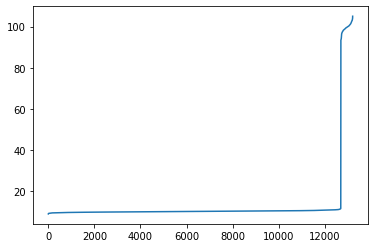

In [0]:
# Plotto il grafico e l'eps migliore è quello in prossimità del "gomito".
plt.plot(single_distances)

In [0]:
# Scelgo il valore in prossimità del gomito
eps = 15

## Lancio DBSCAN

In [0]:
# Lancio DBSCAN sui dati casuali.
clustery = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
start_time = time.time()
clustery.fit(dummy_specs_sample)
end_time = time.time()
print("Tempo di esecuzione:", end_time - start_time)
# Termina in un tempo accettabile su un sample dei dati. Su Colab ci ha mezzo mezz'ora su tutti i dati.

Tempo di esecuzione: 11.669676065444946


In [0]:
# Array dove ogni elemento corrisponde a un esempio e il valore è il cluster di appartenenza.
labels = clustery.labels_
# Numero di cluster trovati.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
# Numero di esempi classificati come rumore (cluster -1).
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
# L'omogeneità è alta se i cluster contengono
# elementi che fanno parte della stessa classe (quindi non contano le label assolute ma i cluster).
# Potrebbe essere calcolata con la ground truth ma è da vedere come.
print("Homogeneity: %0.3f" % metrics.homogeneity_score(dummy_labels_sample, labels))
# La completezza è alta se gli esempi che fanno parte di una classe sono assegnati allo stesso cluster.
print("Completeness: %0.3f" % metrics.completeness_score(dummy_labels_sample, labels))
# V-measure è la media armonica tra omogeneità e completezza.
print("V-measure: %0.3f" % metrics.v_measure_score(dummy_labels_sample, labels))
# Adjusted rand index confronta tutte le coppie di esempi tra ground truth e risultato del clustering,
# e tira fuori una similarità tra i due.
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(dummy_labels_sample, labels))
# Adjusted mutual information è una cosa simile ad adjusted rand index.
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(dummy_labels_sample, labels))
# Silhouette coefficient calcola la distanza intra-cluster e inter-cluster e le usa per dare una metrica
# compresa tra -1 e 1 (non sono necessarie le labels!).
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(dummy_specs_sample, labels))

Estimated number of clusters: 926
Estimated number of noise points: 516
Homogeneity: 0.976
Completeness: 1.000
V-measure: 0.988
Adjusted Rand Index: 0.568
Adjusted Mutual Information: 0.969
Silhouette Coefficient: 0.861


# Prova di clustering su un DataFrame dummy con OPTICS

In [0]:
# Genero dati a caso (della stessa dimensione di quelli veri)
dummy_specs = np.random.randn(528519, 200)

In [0]:
# Lancio OPTICS sui dati casuali.
start_time = time.time()
# Diminuendo max_eps l'algoritmo è più veloce.
clustery = OPTICS(max_eps=0.0000000001, n_jobs=-1)
clustery.fit(dummy_specs)
end_time = time.time()
print(end_time - start_time)
# Non termina mai anche con un max_eps bassissimo...

KeyboardInterrupt: 

# Valutazione

In [0]:
# Genero un dataset fake
attr_to_array = {"www.shopmania.in//1547//af illuminator": np.random.randn(300),
                 "www.shopmania.in//1066//af illuminator": np.random.randn(300),
                 "www.shopmania.in//859//af illuminator": np.random.randn(300),
                 "www.ilgs.net//24//auto focus af assist beam": np.random.randn(300)}
attributes = attr_to_array.keys()

In [0]:
# Genero dei cluster fake
clusters = [0, 0, 0, 1]

In [0]:
# Genero la mappa attributo -> cluster
attr_to_cluster = dict(zip(attributes, clusters))
attr_to_cluster

{'www.ilgs.net//24//auto focus af assist beam': 1,
 'www.shopmania.in//1066//af illuminator': 0,
 'www.shopmania.in//1547//af illuminator': 0,
 'www.shopmania.in//859//af illuminator': 0}

In [0]:
# Calcolo tp, fp e fn su una parte della ground truth.
with open('/content/drive/My Drive/agiw/gt.csv', newline='') as gtfile:
  csvreader = csv.reader(gtfile, delimiter=",")
  tp = 0
  fp = 0
  fn = 0
  for i, row in enumerate(csvreader):

    if i == 0:
      continue
    
    left_ia = row[2]
    right_ia = row[3]
    label = row[6]
    
    # Se uno dei due attributi della gt non era nel nostro dataset, non lo consideriamo.
    if left_ia in attr_to_cluster and right_ia in attr_to_cluster:
      left_cluster = attr_to_cluster[left_ia]
      right_cluster = attr_to_cluster[right_ia]

      # Esaminiamo il caso di un esempio positivo.
      if label == "1":
        # Se gli attributi sono nello stesso cluster, abbiamo un true positive.
        if left_cluster == right_cluster:
          tp += 1
        # Se gli attributi non sono nello stesso cluster, abbiamo un false negative.
        else:
          fn += 1
      # Esaminiamo il caso di un esempio negativo.
      elif label == "0":
        # Se gli attributi sono nello stesso cluster, abbiamo un false positive.
        if left_cluster == right_cluster:
          fp += 1
        # Se gli attributi non sono nello stesso cluster, abbiamo un true negative, che non ci serve ai fini di precision e recall.
      
    if(i >= 2):
      break

In [0]:
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = (2 * precision * recall) / (precision + recall)
print("Precision:", precision, "Recall:", recall, "F1:", f1)

Precision: 1.0 Recall: 0.5 F1: 0.6666666666666666
